In [5]:
import pandas as pd
import numpy as np
import pandas_datareader as wb
import matplotlib.pyplot as plt


# Introduction

In this notebook I try to find ways to make a simple trading algorithm that is profitable. In doing so I explore the characteristics of stock price behaviour. Parts of this notebook are designed for multiple stock data while others are designed for single stock data. Pick either of the following two cells and run the get_data function (3rd cell) to get started. 

The metrics I use to determine model/strategy succes is the profit it makes when used in the trading algorithm. I'm not very interested in R2 or other scores because in the end my goal is to make money.

In [27]:
# Single stock
'''
Use this cell if you want to use the single stock data part of this notebook. 
The cell below can be used for multiple stocks 
'''

tickers = ['HEIA.AS']

In [47]:
# Multi stock
'''
Use this cell if you want to use the multiple stock data part of this notebook. 
The cell above can be used for single stocks 
'''

tickers = ['RDSA.AS', 'REN.AS', 'AD.AS', 'WKL.AS', 'DSM.AS', 'MT.AS', 
'PHIA.AS', 'KPN.AS', 'ASML.AS', 'ASM.AS', 'ABN.AS', 'GLPG.AS', 'AGN.AS',
'NN.AS', 'UNA.AS', 'AKZA.AS', 'HEIA.AS', 'RAND.AS', 'INGA.AS' ]

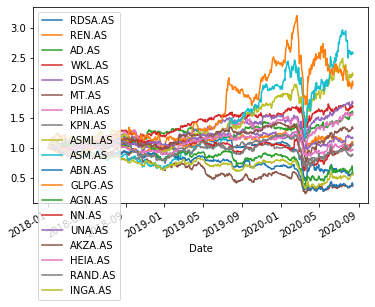

In [52]:

start_date = '2018-01-01'

# Request tickers data
def get_data(tickers=tickers, start_date=start_date, fix_date=False):
    '''
    Gets stock data from the Yahoo API.

    Inputs:
        tickers: The stock tickers that you want to get data from
        start_date: The starting date from which you want your data
        fix_date: Set this to true if you want to use ...

    Output:
        df: the data frame with all the data
    '''
    
    if len(tickers) == 1:
        df = wb.DataReader(tickers[0], 'yahoo', start_date)
    else:
        df = wb.DataReader(tickers, 'yahoo', start_date)

    # Optional fix datetime index
    if fix_date:
        df.index = pd.DatetimeIndex(df.index).to_period('D')

    # Plot normalised returns
    (df['Adj Close'] / df['Adj Close'].iloc[0]).plot()
    plt.legend(loc=2)
    plt.show()

    return df

df = get_data()

# Data engineering



In [53]:
def feature_engineering(df=df, tickers=tickers):
    '''
    Adds features to the data frame in 3 parts. The first part adds lags of the returns (1 to 5 days),
    the second part adds a 'high minus low' spread which is the highest price of a stock minus the lowest.
    This represents volatility. 1 to 3 days lags are made of this HL spread after which the HL spread 
    is removed because it holds information about the day which we want to predict (the current day). 
    The last part adds a categorical return variable that is 1 if stock return is positive and 0 otherwise.

    Input:
        df: The date frame to apply feature engineering to
        tickers: The tickers that the df contains

    Output:
        df: the data frame with added features
    
    '''
    if len(tickers) == 1:
        # Return column
        df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

        # 1-5 day lags
        df['1_day_lag'] = df['Returns'].shift(1)
        df['2_day_lag'] = df['Returns'].shift(2)
        df['3_day_lag'] = df['Returns'].shift(3)
        df['4_day_lag'] = df['Returns'].shift(4)
        df['5_day_lag'] = df['Returns'].shift(5)

        #High-Low spread
        df['HL_spread'] = (df['High'] - df['Low']) / df['Close']
        df['HL_lag_1'] = df['HL_spread'].shift(1)
        df['HL_lag_2'] = df['HL_spread'].shift(2)
        df['HL_lag_3'] = df['HL_spread'].shift(3)
        df.drop('HL_spread', axis=1, inplace=True)

        # Categorical return (1 if > 0 and 0 otherwise)
        df['Cat_return'] = np.multiply(df['Returns'] > 0, 1)
    else:
        for tick in tickers:
            # Return column
            df['Returns', tick] = np.log(df['Adj Close', tick] / df['Adj Close', tick].shift(1))

            # 1-5 day lags
            df['1_day_lag', tick] = df['Returns', tick].shift(1)
            df['2_day_lag', tick] = df['Returns', tick].shift(2)
            df['3_day_lag', tick] = df['Returns', tick].shift(3)
            df['4_day_lag', tick] = df['Returns', tick].shift(4)
            df['5_day_lag', tick] = df['Returns', tick].shift(5)

            #High-Low spread
            df['HL_spread', tick] = (df['High', tick] - df['Low', tick]) / df['Close', tick]
            df['HL_lag_1', tick] = df['HL_spread', tick].shift(1)
            df['HL_lag_2', tick] = df['HL_spread', tick].shift(2)
            df['HL_lag_3', tick] = df['HL_spread', tick].shift(3)
            df.drop('HL_spread', axis=1, inplace=True)

            # Categorical return (1 if > 0 and 0 otherwise)
            df['Cat_return', tick] = np.multiply(df['Returns', tick] > 0, 1)

    # Drop nan's 
    df.dropna(axis=0, inplace=True)

    #df = df.stack()

    return df

df = feature_engineering()


In [30]:
X = df[['1_day_lag', '2_day_lag', '3_day_lag',
        '4_day_lag', '5_day_lag', 
        #'HL_lag_1', 'HL_lag_2','HL_lag_3'
        ]]
y = df['Returns']
y_cat = df['Cat_return']

df_len = X.shape[0]
test_size = 0.2 

X_test = X.tail(int(df_len * test_size))
X_train = X.head(int(df_len * (1 - test_size)))

y_test = y.tail(int(df_len * test_size))
y_train = y.head(int(df_len * (1 - test_size)))

y_cat_test = y_cat.tail(int(df_len * test_size))
y_cat_train = y_cat.head(int(df_len * (1 - test_size)))


# Data analysis



In [31]:

print('Number of trading days (rows): ', df.shape[0])
print(df.tail()) 
print(df.info())

Number of trading days (rows):  662
                 High        Low       Open      Close    Volume  Adj Close  \
Date                                                                          
2020-08-10  77.320000  76.400002  77.000000  77.320000  455361.0  77.320000   
2020-08-11  79.199997  77.620003  77.639999  78.459999  628403.0  78.459999   
2020-08-12  79.580002  78.019997  78.480003  79.540001  486168.0  79.540001   
2020-08-13  79.639999  78.820000  79.300003  79.339996  375695.0  79.339996   
2020-08-14  79.300003  77.300003  79.300003  77.879997  228252.0  77.879997   

             Returns  1_day_lag  2_day_lag  3_day_lag  4_day_lag  5_day_lag  \
Date                                                                          
2020-08-10  0.010662  -0.002872  -0.022426  -0.012413  -0.014000  -0.020640   
2020-08-11  0.014636   0.010662  -0.002872  -0.022426  -0.012413  -0.014000   
2020-08-12  0.013671   0.014636   0.010662  -0.002872  -0.022426  -0.012413   
2020-08-13 -0.0

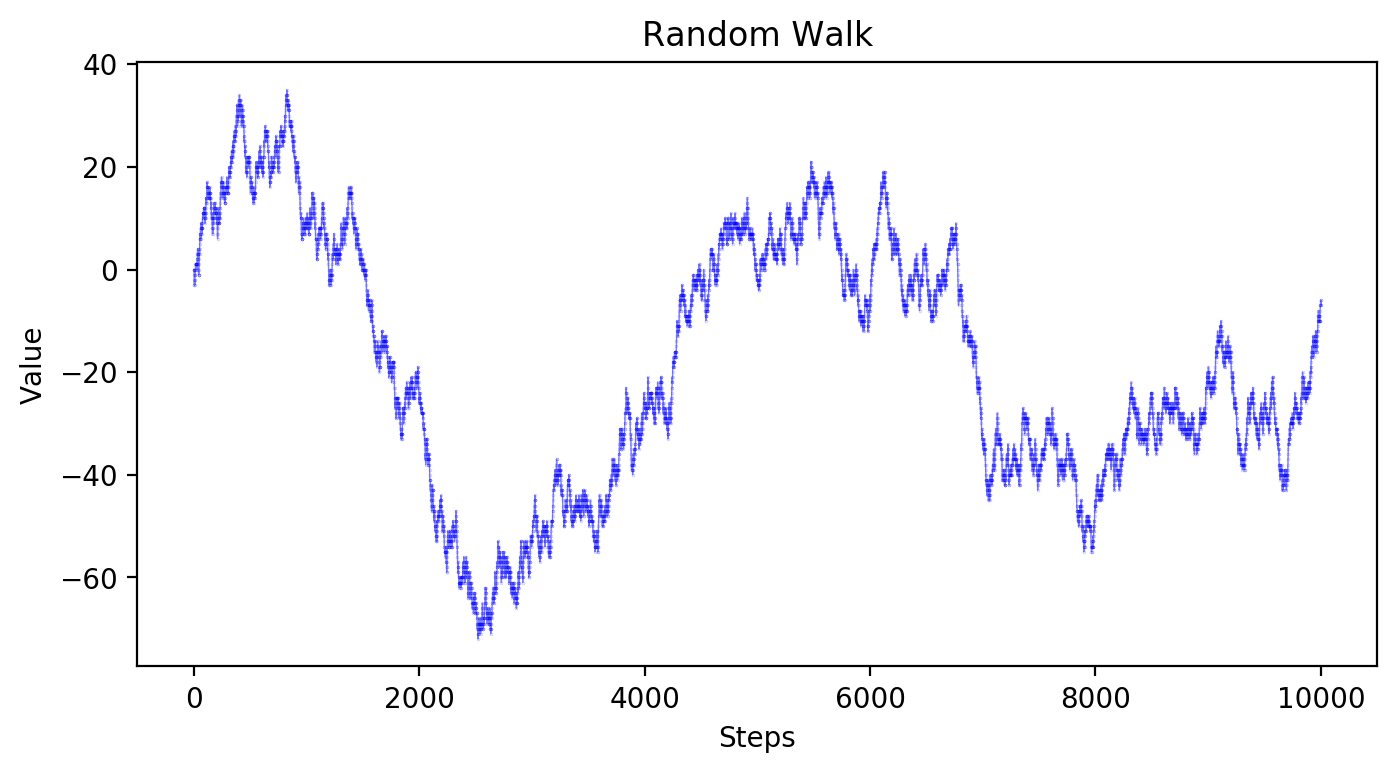

In [24]:
'''
Random walk simulation to see how similar it looks to stock returns
'''
# Define parameters for the walk
step_n = 10000
step_set = [-1, 0, 1]
origin = np.zeros((1, 1))

# Simulate steps
step_shape = (step_n, 1)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)

# Plot the path
fig = plt.figure(figsize=(8,4),dpi=200)
ax = fig.add_subplot(111)
ax.scatter(np.arange(step_n+1), path, c='blue', alpha=0.25,s=0.05);
ax.plot(path,c='blue',alpha=0.5, lw=0.5, ls='-',);
plt.title('Random Walk')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.show()


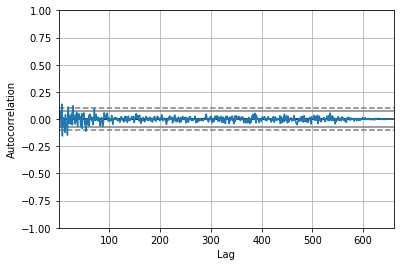

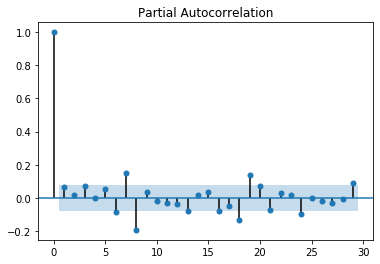

In [11]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

# Autocorrelation
autocorrelation_plot(df['Returns'])
plt.show()

# Partial autocorrelation
plot_pacf(df['Returns'])
plt.show()

On the autocorrelation graph we can see that the current return shows some small correlation with returns up to a few days earlier. We can see this because the lines at the start exceed the grey horizontal dashed line meaning correlation is statistically significant.

The partial autocorrelation graph shows that when controlling for multicollinearity there is no correlation left for the first 5 lags. After that there are some minor correlations found but these are probably due to randomness.

# Models and trading algorithms

In this section I test a few models and trading algorithms and show the results they produce

In [57]:
def single_stock_algorithm(predictions, true_ret=y_test, capital=100_000, t_cost=1, short=False):
    '''
    Can use predictions made on the X_test data set for a naive trading algorithm. 
    If prediction > 0 it will buy the stock and if shorting is allowed will do the
    opposite. 

    Input:
        predictions: The predictions on the X_test data set to be used
        true_ret: The true returns to which we compare our predictions (default y_test)
        capital: How much capital is put into the stock (default 100.000)
        t_cost: transaction cost (default of 1)
        short: True if shorting is allowed and false (default) if not
    '''

    num_trade = 0

    zipper = zip(true_ret, predictions)

    for ret, pred in zipper:
        if pred > 0:
            capital = (1 + ret) * capital - t_cost * 2
            num_trade += 1
        if short:
            if pred < 0:
                capital = (1 - ret) * capital - t_cost * 2
                num_trade += 1

    print('Waarde:', round(capital), 'Euro')
    print('Winst:', int(capital) - 100_000, 'Euro')
    print('Number of trades:', num_trade)
    print('Transaction cost:', num_trade * t_cost * 2, end='\n\n')



C:\Users\a_arj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


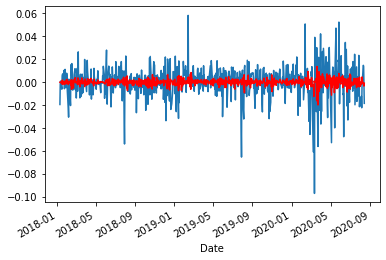

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
pd.plotting.register_matplotlib_converters()

model = ARIMA(df['Returns'], order=(2, 0, 10))
results = model.fit(disp=-1)

df['Returns'].plot()
plt.plot(results.fittedvalues, color='red')
plt.show()

In [38]:
single_stock_algorithm(results.fittedvalues, df['Returns'], short=True)

Waarde: 226563 Euro
Winst: 126563 Euro
Number of trades: 662
Transaction cost: 1324



In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#instantiate linear model
lm = LinearRegression()

#fit the model to the training set
lm.fit(X_train, y_train)

#predict using the test set and training set
lm_preds = lm.predict(X_test)

#score the two predictions above
score_test = r2_score(y_test, lm_preds)

#create a new table with coefficiencts found by the model
coefs = pd.DataFrame()
coefs['feature'] = X.columns
coefs['coefficient'] = lm.coef_
coefs['absolute coef'] = np.abs(lm.coef_)

#sort the coefficients from large to small and add an extra row with the intercept at 
#the bottom of the table
coefs = coefs.sort_values('absolute coef', ascending=False)
coefs = coefs.append({'feature':'Intercept', 'coefficient':lm.intercept_, \
                      'absolute coef':np.abs(lm.intercept_)}, ignore_index=True)

print(coefs, end='\n\n')

lm_error = np.mean(abs(lm_preds - y_test))

print("Average error:", round(lm_error, 3))
print("R2-score of the model on the test data:", round(score_test,3))

feature  coefficient  absolute coef
0  5_day_lag     0.099756       0.099756
1  4_day_lag    -0.080864       0.080864
2  3_day_lag    -0.074477       0.074477
3  1_day_lag    -0.023642       0.023642
4  2_day_lag    -0.004957       0.004957
5  Intercept     0.000289       0.000289

Average error: 0.016
R2-score of the model on the test data: -0.024


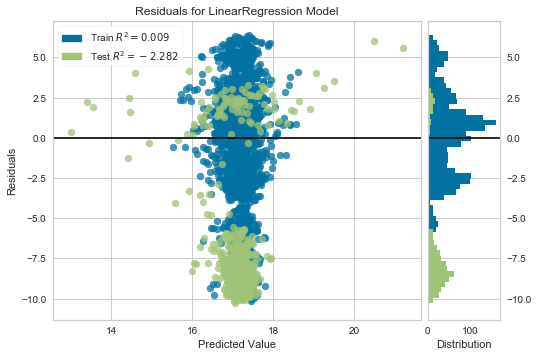

In [26]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lm)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [43]:
single_stock_algorithm(lm_preds, short=True)

Waarde: 117522 Euro
Winst: 17521 Euro
Number of trades: 132
Transaction cost: 264



In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 10, n_jobs=2)

#fit the model to the training set
rf.fit(X_train, y_train)

#predict on the test set
rf_preds = rf.predict(X_test)

#score the prediction
rf_r2_score = r2_score(y_test, rf_preds)

#calculate average error between prediction and known y-value
rf_error = np.mean(abs(rf_preds - y_test))

#print results
print("Average error:", round(rf_error, 3))
print("R2-score of the model on the test data:", round(rf_r2_score,3))

Average error: 0.017
R2-score of the model on the test data: -0.133


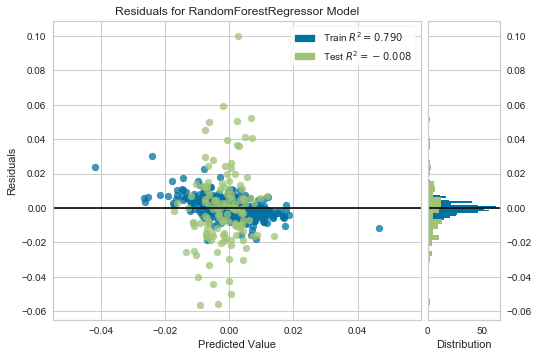

In [41]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

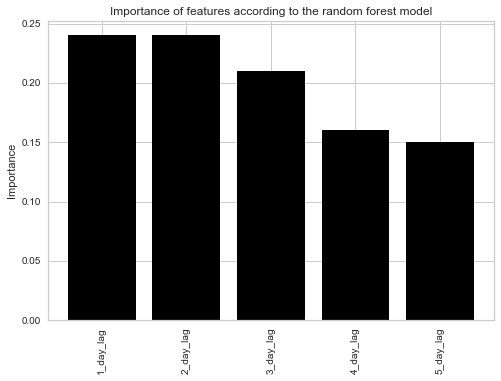

In [42]:
importance = list(rf.feature_importances_.round(2))
importance.sort(reverse=True)
features = list(X.columns)

x_values = np.array(list(range(len(importance))))
plt.bar(features, importance, color='black')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.title('Importance of features according to the random forest model')
plt.show()

In [45]:
single_stock_algorithm(rf_preds, short=True)

Waarde: 141263 Euro
Winst: 41263 Euro
Number of trades: 132
Transaction cost: 264



In [11]:
from sklearn.svm import SVC

clf = SVC(gamma='scale')
clf.fit(X_train, y_cat_train)
svc_pred = clf.predict(X_test)

print('Accuracy: ' + str(int((y_cat_test== svc_pred).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 52%


In [12]:
# Baseline prediction which assumes positive returns every day
all_one = [1] * len(y_cat_test)
print('Accuracy: ' + str(int((y_cat_test == all_one).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 49%


In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=1000, n_jobs=2)
clf_rf.fit(X_train, y_cat_train)

clf_rf_pred = clf_rf.predict(X_test)

print('Accuracy: ' + str(int((y_cat_test == clf_rf_pred).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 51%


In [55]:
# Naive trading algorithm for multiple stocks. If the stock went up yesterday, go long. If the stock went down, go short
'''
Use multiple stock tickers for this part
'''
transactie_kosten = 2

buy_n_hold_total = 0
strat_total = 0 

starting_capital = 1000_00

for tick in tickers:
    capital = starting_capital
    num_trade = 0

    zipper = zip(df['Returns'][tick], df['1_day_lag'][tick])

    for ret, lag in zipper:
        # Long
        if lag > 0:
            capital = (1 + ret) * capital - transactie_kosten
            num_trade += 1
        # Short
        elif lag < 0:
            capital = (1 - ret) * capital - transactie_kosten
            num_trade += 1    

    strat_total += capital
    buy_n_hold = df['Adj Close'][tick].iloc[-1] / df['Adj Close'][tick].iloc[0] * starting_capital
    buy_n_hold_total += buy_n_hold

    print(tick)
    print(int(buy_n_hold), 
    'Euro with buy en hold')
    print(int(capital), 'Euro with our strategy')
    print('in', num_trade, 'Trades', end='\n\n')  

RDSA.AS
54159 Euro with buy en hold
326052 Euro with our strategy
in 662 Trades

REN.AS
110629 Euro with buy en hold
50849 Euro with our strategy
in 650 Trades

AD.AS
160797 Euro with buy en hold
93280 Euro with our strategy
in 652 Trades

WKL.AS
166653 Euro with buy en hold
92432 Euro with our strategy
in 650 Trades

DSM.AS
171205 Euro with buy en hold
88447 Euro with our strategy
in 651 Trades

MT.AS
33979 Euro with buy en hold
108294 Euro with our strategy
in 661 Trades

PHIA.AS
146655 Euro with buy en hold
73944 Euro with our strategy
in 659 Trades

KPN.AS
90350 Euro with buy en hold
50149 Euro with our strategy
in 648 Trades

ASML.AS
215178 Euro with buy en hold
83905 Euro with our strategy
in 658 Trades

ASM.AS
254361 Euro with buy en hold
44452 Euro with our strategy
in 658 Trades

ABN.AS
37069 Euro with buy en hold
109754 Euro with our strategy
in 655 Trades

GLPG.AS
184711 Euro with buy en hold
214957 Euro with our strategy
in 659 Trades

AGN.AS
53592 Euro with buy en hold
913

In [56]:
total_start_cap = len(tickers) * starting_capital
print(total_start_cap)
print('Buy n hold winst:', int(buy_n_hold_total) - total_start_cap, 'Euro')
print('Strat winst:', int(strat_total) - total_start_cap, 'Euro')

1900000
Buy n hold winst: 368138 Euro
Strat winst: 173731 Euro


# Results discussion and improvements

The average profit from buy and hold is over 2 times that of the naive trading algorithm and the models are even worse. The models did however all result in a profit which was more than I had expected. Only the random forest model had more diverging results where sometimes the profit became negative. 

The classification models that only predict positive or negative returns show that its about 50/50 (slightly biassed to positive) whether returns will be positive or negative. This is evidence for the idea that short term stock returns are random.

My results are not conclusive because of there are many more models who might be better at predicting than the models I used. Neural networks might be a good start for further research.

If we truly want to automate a good trading strategy we will have to incorporate more information about the company's we want to trade such as financial performance and health. Also a twitter sentiment analysis might prove useful for predicting whether the market will go up or down the next day. 


# Conclusion

To conclude I advise you to just buy and hold stocks because that has proven to garner much higher returns than any of the models I tested here. If you do want to automate a trading algorithm you should use the naive algorithm that buys a stock if yesterday's returns were positive and shorts (sell a borrowed stock) if yesterday's returns were negative.

